In [13]:
import numpy as np
import glob
import pandas as pd
import tensorflow as tf

%timeit

In [2]:
df = pd.read_csv('car_augmented_file.csv')


In [8]:
df.head()

,car_url_id,is_premium,label,cars_image
0,2010-xuefolan-lechi-d77BsJBbW9uE,False,0,2010-xuefolan-lechi-d77BsJBbW9uE.txt
1,2009-fengtian-weichi-dIIJBBIhZZWZ,False,0,2009-fengtian-weichi-dIIJBBIhZZWZ.txt
2,2014-MINI-COOPER-dB7k0BBZ9XbX,True,1,2014-MINI-COOPER-dB7k0BBZ9XbX.txt
3,2013-aodi-A4L-dBs0iJQXuXwX,True,1,2013-aodi-A4L-dBs0iJQXuXwX.txt
4,2009-kaidilake-CTS-d00QkBJbwwhN,True,1,2009-kaidilake-CTS-d00QkBJbwwhN.txt


In [5]:
#convert the cars_image data extension from png to txt; png_ to txt_
#because the converted alexnet data stored int .txt format instead of png format
df['cars_image'] = df['car_url_id'].apply(lambda v: v+'.txt')

In [9]:
df.head(5)

,car_url_id,is_premium,label,cars_image
0,2010-xuefolan-lechi-d77BsJBbW9uE,False,0,2010-xuefolan-lechi-d77BsJBbW9uE.txt
1,2009-fengtian-weichi-dIIJBBIhZZWZ,False,0,2009-fengtian-weichi-dIIJBBIhZZWZ.txt
2,2014-MINI-COOPER-dB7k0BBZ9XbX,True,1,2014-MINI-COOPER-dB7k0BBZ9XbX.txt
3,2013-aodi-A4L-dBs0iJQXuXwX,True,1,2013-aodi-A4L-dBs0iJQXuXwX.txt
4,2009-kaidilake-CTS-d00QkBJbwwhN,True,1,2009-kaidilake-CTS-d00QkBJbwwhN.txt


In [14]:
%%time
extracted_alexnet = []

#base on the order of the image file name, load the extracted VGG features into extracted_VGG[]
for f in df['cars_image']:
    
    extracted_features = np.loadtxt('extracted_alex/{}'.format(f))
    extracted_alexnet.append(extracted_features)

CPU times: user 33.4 s, sys: 4.69 s, total: 38.1 s
Wall time: 49.5 s


In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()



onehot_labels = encoder.fit_transform(labels.reshape([-1,1]))
onehot_labels= onehot_labels.todense()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [21]:
#split the dataset into training and testing, this should be same as previous network
num_dat = int(len(df) * 0.7)

train_dat = extracted_alexnet[:num_dat]
train_label_one_hot = onehot_labels[:num_dat]

test_dat = extracted_alexnet[num_dat:]
test_label_one_hot = onehot_labels[num_dat:]

train_dat = np.array(train_dat)
test_dat= np.array(test_dat)

#the expected alexnet converted data should be in N samples x 4096
print(train_dat.shape, test_dat.shape)
print(train_label_one_hot.shape, test_label_one_hot.shape)

(4209, 4096) (1805, 4096)
(4209, 2) (1805, 2)


In [22]:
#build simple neural network tensorflow graph which accepts 4096 dimension
import tensorflow as tf
from sklearn.metrics import *

x = tf.placeholder(tf.float32, [None, 4096])

W = tf.Variable(tf.zeros([4096, 2]))
b = tf.Variable(tf.zeros([2]))

y_pred = tf.nn.softmax(tf.matmul(x, W) + b)
y_true = tf.placeholder(tf.float32, [None, 2])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y_pred), reduction_indices=[1]))

test_true = tf.placeholder(tf.float32, [None, 2])
predicted_test = tf.placeholder(tf.float32, [None, 2])
test_entropy = tf.reduce_mean(-tf.reduce_sum(test_true * tf.log(predicted_test), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

init = tf.global_variables_initializer()

In [23]:
 #list to track the accuracy for plotting later
train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []

#instance to save the trained model
saver = tf.train.Saver()

In [24]:
    %%time
    steps = 10000

    sess = tf.Session()
    
    sess.run(init)
    
    
    for epochs in range(steps):
        
        pred_y, _, train_loss = sess.run([y_pred, train_step,cross_entropy],feed_dict={x:train_dat,y_true:train_label_one_hot})
        
        # PRINT OUT A MESSAGE EVERY 50 STEPS
        if epochs%50 == 0:
            print("\n\nEpoch", epochs)

            train_accuracy = np.mean(np.equal(np.argmax(pred_y, axis = 1), np.argmax(train_label_one_hot, axis = 1).flatten()))
            print("# Train Accuracy", train_accuracy, "  Loss", train_loss)
            print(classification_report(np.argmax(pred_y, axis = 1),np.argmax(train_label_one_hot, axis = 1)))
            
            #save the accuracy for training
            train_acc_history.append(train_accuracy)
            train_loss_history.append(train_loss)
            
            # Predictions validation
            pred_y_test = sess.run(y_pred,feed_dict={x:test_dat,y_true:test_label_one_hot})
            
            test_loss = sess.run(test_entropy, feed_dict={predicted_test:pred_y_test,test_true:test_label_one_hot})
            test_loss_history.append(test_loss)
            
            pred_y_test_val = np.argmax(pred_y_test, axis = 1)
            test_label_val = np.argmax(test_label_one_hot, axis = 1)
            
            test_accuracy = np.mean(np.equal(pred_y_test_val, test_label_val.flatten()))
            print("# Test Accuracy", test_accuracy, "  Loss", test_loss)
            print(classification_report(pred_y_test_val, test_label_val))
 
            print(confusion_matrix(pred_y_test_val, test_label_val))

            test_acc_history.append(test_accuracy)
            
        #break
 
    #once we done all the training and testing, save the trained model for future use
    saver.save(sess, './saved_model_alexnet/Alex_DNN.ckpt') 
    sess.close()



Epoch 0
# Train Accuracy 0.5269660251841293   Loss 0.69314593
             precision    recall  f1-score   support

          0       1.00      0.53      0.69      4209
          1       0.00      0.00      0.00         0

avg / total       1.00      0.53      0.69      4209

# Test Accuracy 0.5218836565096953   Loss 0.7027619
             precision    recall  f1-score   support

          0       1.00      0.52      0.69      1805
          1       0.00      0.00      0.00         0

avg / total       1.00      0.52      0.69      1805

[[942 863]
 [  0   0]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




Epoch 50
# Train Accuracy 0.6398194345450225   Loss 1.2295539
             precision    recall  f1-score   support

          0       0.35      0.91      0.51       852
          1       0.96      0.57      0.72      3357

avg / total       0.84      0.64      0.67      4209

# Test Accuracy 0.6155124653739612   Loss 1.36906
             precision    recall  f1-score   support

          0       0.96      0.58      0.72      1566
          1       0.24      0.85      0.37       239

avg / total       0.87      0.62      0.68      1805

[[907 659]
 [ 35 204]]


Epoch 100
# Train Accuracy 0.6728439059158945   Loss 1.0262781
             precision    recall  f1-score   support

          0       0.42      0.92      0.57      1007
          1       0.96      0.60      0.73      3202

avg / total       0.83      0.67      0.70      4209

# Test Accuracy 0.6343490304709142   Loss 1.188208
             precision    recall  f1-score   support

          0       0.95      0.59      0.73      



Epoch 800
# Train Accuracy 0.8037538607745308   Loss 0.46853
             precision    recall  f1-score   support

          0       0.65      0.97      0.78      1496
          1       0.97      0.71      0.82      2713

avg / total       0.86      0.80      0.81      4209

# Test Accuracy 0.7141274238227147   Loss 0.7442457
             precision    recall  f1-score   support

          0       0.93      0.66      0.77      1322
          1       0.48      0.86      0.62       483

avg / total       0.81      0.71      0.73      1805

[[874 448]
 [ 68 415]]


Epoch 850
# Train Accuracy 0.810168686148729   Loss 0.45200634
             precision    recall  f1-score   support

          0       0.66      0.97      0.79      1521
          1       0.97      0.72      0.83      2688

avg / total       0.86      0.81      0.81      4209

# Test Accuracy 0.7196675900277009   Loss 0.73358583
             precision    recall  f1-score   support

          0       0.93      0.67      0.78   



Epoch 1550
# Train Accuracy 0.8702779757662152   Loss 0.2924195
             precision    recall  f1-score   support

          0       0.77      0.98      0.86      1750
          1       0.98      0.79      0.88      2459

avg / total       0.89      0.87      0.87      4209

# Test Accuracy 0.7351800554016621   Loss 0.63535106
             precision    recall  f1-score   support

          0       0.89      0.69      0.78      1218
          1       0.56      0.83      0.67       587

avg / total       0.79      0.74      0.74      1805

[[841 377]
 [101 486]]


Epoch 1600
# Train Accuracy 0.874792112140651   Loss 0.28444394
             precision    recall  f1-score   support

          0       0.78      0.98      0.87      1769
          1       0.98      0.80      0.88      2440

avg / total       0.90      0.87      0.88      4209

# Test Accuracy 0.7373961218836566   Loss 0.630673
             precision    recall  f1-score   support

          0       0.89      0.69      0.78



Epoch 2300
# Train Accuracy 0.9223093371347113   Loss 0.1994303
             precision    recall  f1-score   support

          0       0.87      0.98      0.92      1967
          1       0.98      0.87      0.92      2242

avg / total       0.93      0.92      0.92      4209

# Test Accuracy 0.7623268698060942   Loss 0.5834695
             precision    recall  f1-score   support

          0       0.86      0.73      0.79      1115
          1       0.65      0.81      0.72       690

avg / total       0.78      0.76      0.77      1805

[[814 301]
 [128 562]]


Epoch 2350
# Train Accuracy 0.9261107151342362   Loss 0.19476467
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      1983
          1       0.98      0.88      0.93      2226

avg / total       0.93      0.93      0.93      4209

# Test Accuracy 0.7634349030470914   Loss 0.5810578
             precision    recall  f1-score   support

          0       0.86      0.73      0.7



Epoch 3050
# Train Accuracy 0.9610358755048705   Loss 0.14479731
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2188
          1       0.97      0.95      0.96      2021

avg / total       0.96      0.96      0.96      4209

# Test Accuracy 0.7689750692520776   Loss 0.5577965
             precision    recall  f1-score   support

          0       0.81      0.76      0.78       997
          1       0.73      0.78      0.75       808

avg / total       0.77      0.77      0.77      1805

[[761 236]
 [181 627]]


Epoch 3100
# Train Accuracy 0.9612734616298408   Loss 0.14295404
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2201
          1       0.96      0.96      0.96      2008

avg / total       0.96      0.96      0.96      4209

# Test Accuracy 0.7750692520775623   Loss 0.5576015
             precision    recall  f1-score   support

          0       0.81      0.77      0.



Epoch 3800
# Train Accuracy 0.9710144927536232   Loss 0.12896763
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2226
          1       0.97      0.97      0.97      1983

avg / total       0.97      0.97      0.97      4209

# Test Accuracy 0.7750692520775623   Loss 0.5704385
             precision    recall  f1-score   support

          0       0.80      0.78      0.79       964
          1       0.75      0.77      0.76       841

avg / total       0.78      0.78      0.78      1805

[[750 214]
 [192 649]]


Epoch 3850
# Train Accuracy 0.9719648372535044   Loss 0.12813136
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2224
          1       0.97      0.97      0.97      1985

avg / total       0.97      0.97      0.97      4209

# Test Accuracy 0.7750692520775623   Loss 0.57152003
             precision    recall  f1-score   support

          0       0.80      0.78      0



Epoch 4550
# Train Accuracy 0.9781420765027322   Loss 0.11756808
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2222
          1       0.98      0.98      0.98      1987

avg / total       0.98      0.98      0.98      4209

# Test Accuracy 0.7767313019390581   Loss 0.58685815
             precision    recall  f1-score   support

          0       0.80      0.78      0.79       967
          1       0.75      0.77      0.76       838

avg / total       0.78      0.78      0.78      1805

[[753 214]
 [189 649]]


Epoch 4600
# Train Accuracy 0.9786172487526729   Loss 0.11688497
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2220
          1       0.98      0.98      0.98      1989

avg / total       0.98      0.98      0.98      4209

# Test Accuracy 0.7767313019390581   Loss 0.587958
             precision    recall  f1-score   support

          0       0.80      0.78      0.



Epoch 5300
# Train Accuracy 0.9821810406272273   Loss 0.10813047
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2219
          1       0.98      0.98      0.98      1990

avg / total       0.98      0.98      0.98      4209

# Test Accuracy 0.775623268698061   Loss 0.60326207
             precision    recall  f1-score   support

          0       0.80      0.78      0.79       967
          1       0.75      0.77      0.76       838

avg / total       0.78      0.78      0.78      1805

[[752 215]
 [190 648]]


Epoch 5350
# Train Accuracy 0.9821810406272273   Loss 0.10755723
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2219
          1       0.98      0.98      0.98      1990

avg / total       0.98      0.98      0.98      4209

# Test Accuracy 0.775623268698061   Loss 0.6043446
             precision    recall  f1-score   support

          0       0.80      0.78      0.7



Epoch 6050
# Train Accuracy 0.9847944880019007   Loss 0.10014384
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2220
          1       0.98      0.98      0.98      1989

avg / total       0.98      0.98      0.98      4209

# Test Accuracy 0.7722991689750692   Loss 0.61929196
             precision    recall  f1-score   support

          0       0.80      0.77      0.78       969
          1       0.75      0.77      0.76       836

avg / total       0.77      0.77      0.77      1805

[[750 219]
 [192 644]]


Epoch 6100
# Train Accuracy 0.985032074126871   Loss 0.099654265
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2219
          1       0.98      0.98      0.98      1990

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7722991689750692   Loss 0.6203433
             precision    recall  f1-score   support

          0       0.80      0.77      0



Epoch 6800
# Train Accuracy 0.9862200047517224   Loss 0.09327887
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2220
          1       0.98      0.99      0.99      1989

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7722991689750692   Loss 0.63481367
             precision    recall  f1-score   support

          0       0.80      0.77      0.78       967
          1       0.75      0.77      0.76       838

avg / total       0.77      0.77      0.77      1805

[[749 218]
 [193 645]]


Epoch 6850
# Train Accuracy 0.9862200047517224   Loss 0.09285503
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2220
          1       0.98      0.99      0.99      1989

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7722991689750692   Loss 0.63582915
             precision    recall  f1-score   support

          0       0.80      0.77      



Epoch 7550
# Train Accuracy 0.9881206937514849   Loss 0.08730423
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2218
          1       0.99      0.99      0.99      1991

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7689750692520776   Loss 0.64978826
             precision    recall  f1-score   support

          0       0.79      0.77      0.78       967
          1       0.74      0.77      0.75       838

avg / total       0.77      0.77      0.77      1805

[[746 221]
 [196 642]]


Epoch 7600
# Train Accuracy 0.9881206937514849   Loss 0.086933166
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2218
          1       0.99      0.99      0.99      1991

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7689750692520776   Loss 0.650767
             precision    recall  f1-score   support

          0       0.79      0.77      0



Epoch 8300
# Train Accuracy 0.9904965550011879   Loss 0.08205075
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2216
          1       0.99      0.99      0.99      1993

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7706371191135734   Loss 0.6642168
             precision    recall  f1-score   support

          0       0.79      0.77      0.78       968
          1       0.75      0.77      0.76       837

avg / total       0.77      0.77      0.77      1805

[[748 220]
 [194 643]]


Epoch 8350
# Train Accuracy 0.9907341411261582   Loss 0.081722856
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2215
          1       0.99      0.99      0.99      1994

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7706371191135734   Loss 0.6651596
             precision    recall  f1-score   support

          0       0.79      0.77      0



Epoch 9050
# Train Accuracy 0.9931100023758612   Loss 0.07739126
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2217
          1       0.99      0.99      0.99      1992

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7722991689750692   Loss 0.6781163
             precision    recall  f1-score   support

          0       0.80      0.77      0.78       969
          1       0.75      0.77      0.76       836

avg / total       0.77      0.77      0.77      1805

[[750 219]
 [192 644]]


Epoch 9100
# Train Accuracy 0.9931100023758612   Loss 0.07709922
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2217
          1       0.99      0.99      0.99      1992

avg / total       0.99      0.99      0.99      4209

# Test Accuracy 0.7722991689750692   Loss 0.67902476
             precision    recall  f1-score   support

          0       0.80      0.77      0



Epoch 9800
# Train Accuracy 0.9950106913756237   Loss 0.07322799
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      2223
          1       0.99      1.00      0.99      1986

avg / total       1.00      1.00      1.00      4209

# Test Accuracy 0.7700831024930748   Loss 0.69151086
             precision    recall  f1-score   support

          0       0.79      0.77      0.78       967
          1       0.75      0.77      0.76       838

avg / total       0.77      0.77      0.77      1805

[[747 220]
 [195 643]]


Epoch 9850
# Train Accuracy 0.9950106913756237   Loss 0.07296612
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      2223
          1       0.99      1.00      0.99      1986

avg / total       1.00      1.00      1.00      4209

# Test Accuracy 0.7695290858725762   Loss 0.69238645
             precision    recall  f1-score   support

          0       0.79      0.77      

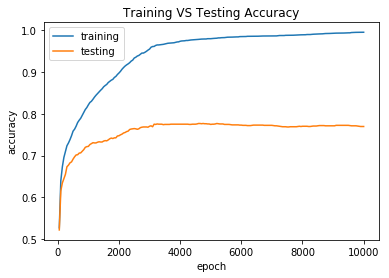

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(1, len(train_acc_history), len(train_acc_history))
x *= 50
plt.plot(x, train_acc_history, label = 'training')
plt.plot(x, test_acc_history, label = 'testing')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training VS Testing Accuracy')
plt.legend()

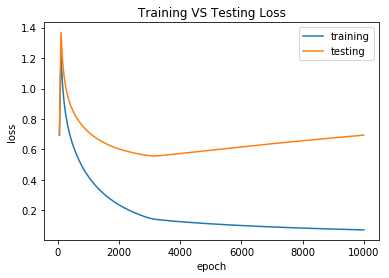

In [26]:
plt.plot(x, train_loss_history, label = 'training')
plt.plot(x, test_loss_history, label = 'testing')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training VS Testing Loss')
plt.legend()

In [15]:
print(np.array(test_acc_history).max())
print(np.array(test_loss_history).min())

0.789473684211
0.517764
